In [64]:
import jax.numpy as jnp
import jax
import equinox as eqx
import cryojax as cx
import cryojax.simulator as cxs
import src.ensemble_sim as sim
from cryojax.image.operators import FourierGaussian
from cryojax.rotations import SO3
import dataclasses
import os
import jax_dataloader as jdl
from typing import Any, Callable, final
from typing_extensions import override



import numpyro
import numpyro.distributions as dist

import logging
from functools import partial

import matplotlib.pyplot as plt

from cryojax.utils import get_filter_spec
from cryojax.utils._filtered_transformations import filter_vmap_with_spec
from cryojax.constants import get_tabulated_scattering_factor_parameters
from cryojax.io import read_atoms_from_pdb

from cryojax.data import RelionParticleStack, RelionParticleParameters,AbstractParticleStack, RelionParticleDataset, AbstractDataset


# Create list of pdb files for simulating images from

In [65]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

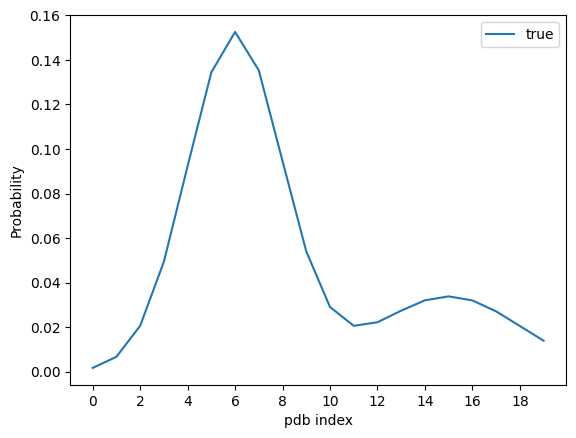

In [66]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = dist.Normal(loc=means, scale=std_devs) 
    return dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= dx*weights.sum() 
plt.plot(x, weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Define a config file for image simulation

In [67]:
# Bare bones config for this notebook
# Things that may need to be adjusted:
#   number of images, noise_snr
# Everything else, unlikely
config = {
"number_of_images": 100,
"noise_snr": 0.001,
"weights_models": weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

# Note: defining new stuff here!!

In [68]:
def _get_particle_stack_filter_spec(particle_stack):
    return get_filter_spec(particle_stack, _pointer_to_vmapped_parameters)

def _pointer_to_vmapped_parameters(particle_stack):
    output = (
        particle_stack.parameters.transfer_theory.ctf.defocus_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_in_angstroms,
        particle_stack.parameters.transfer_theory.ctf.astigmatism_angle,
        particle_stack.parameters.transfer_theory.ctf.phase_shift,
        particle_stack.parameters.transfer_theory.envelope.b_factor,
        #particle_stack.parameters.transfer_theory.envelope.amplitude,
        particle_stack.parameters.pose.offset_x_in_angstroms,
        particle_stack.parameters.pose.offset_y_in_angstroms,
        particle_stack.parameters.pose.view_phi,
        particle_stack.parameters.pose.view_theta,
        particle_stack.parameters.pose.view_psi,
        particle_stack.image_stack,
    )
    return output



In [69]:
#@dataclasses.dataclass(frozen=True)
#class BasicParticleDataset(AbstractDataset):
#    """
#    (docstring from Abstract dataset)
#   mplement its `__init__`, `__getitem__`, and
#    `__len__` methods.
#
#    This follows the
#    [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
#    API and can easily be wrapped into a pytorch `Dataset` with the
#    following pattern:
#
#    ```python
#    import numpy as np
#    from torch.utils.data import Dataset
#
#    class CustomTorchDataset(Dataset):
#
#        def __init__(cryojax_dataset: AbstractDataset):
#            self.cryojax_dataset = cryojax_dataset
#
#        def __getitem___(self, index) -> dict[str, Array]:
#            particle_stack = self.cryojax_dataset[index]
#            return dict(index=index, image_stack=np.asarray(particle_stack.image_stack))
#
#        def __len__(self) -> int:
#            return len(self.cryojax_dataset)
#    ``` 
#    """
#    metadata: RelionParticleMetadata
#    get_cpu_arrays: bool
#
#    @final
#    def __init__(self, metadata: RelionParticleMetadata, get_cpu_arrays: bool = False):
#        """**Arguments:**
#
#        - `metadata`:
#            The `RelionParticleMetadata`.
#        - `get_cpu_arrays`:
#            If `True`, force that JAX arrays for images are loaded on the CPU.
#            If `False`, load on the default device.
#        """
#        object.__setattr__(self, "metadata", metadata)
#        object.__setattr__(self, "get_cpu_arrays", get_cpu_arrays)
#
#    @final
#    def __getitem__(
#        self, index: int | slice | Int[np.ndarray, ""] | Int[np.ndarray, " N"]
#    ) -> RelionParticleStack:
#        # First, load image parameters into cryoJAX objects
#        instrument_config, transfer_theory, pose = 
#        
#        _make_pytrees_from_starfile_metadata(
#            particle_blocks,
#            optics_group,
#            jax.devices("cpu")[0] if self.metadata.get_cpu_arrays else None,
#            self.metadata.get_envelope_function,
#            self.metadata.make_instrument_config_fn,
#        )
#        # Then, load stack of images
#        # TODO: this is the batch-wise image computing function 
#        image_stack = _get_image_stack_from_mrc(
#            index,
#            particle_blocks,
#            jax.devices("cpu")[0] if self.get_cpu_arrays else None,
#            self.metadata.path_to_relion_project,
#        )
#
#        return RelionParticleStack(
#            RelionParticleParameters(instrument_config, pose, transfer_theory)
#            parameters,
#            image_stack,
#        )
#
#    @final
#    def __len__(self) -> int:
#        return len(self.metadata.data_blocks["particles"])
#
#class CustomJaxDataset(jdl.Dataset):
#    def __init__(self, cryojax_dataset: BasicParticleDataset):
#        self.cryojax_dataset = cryojax_dataset
#
#    def __getitem__(self, index) -> RelionParticleStack:
#        return self.cryojax_dataset[index]
#
#    def __len__(self) -> int:
#        return len(self.cryojax_dataset)
#    
#
#

In [70]:
#dataloader = jdl.DataLoader(
#        CustomJaxDataset(
#            particle_reader
#        ),  # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
#        backend="jax",  # Use 'jax' backend for loading data
#        batch_size=2000,  # Batch size
#        shuffle=False,  # Shuffle the dataloader every iteration or not
#        drop_last=False,  # Drop the last batch or not
#    )

In [71]:
def compute_image_stack_with_noise(key, config, imaging_pipeline, noise_args):
    # Define what we vmap over
    filter_spec = sim._get_imaging_pipeline_filter_spec(imaging_pipeline)

    # Compute clean images, with fancy vmapping
    @partial(filter_vmap_with_spec, filter_spec=filter_spec)
    def compute_image_stack(imaging_pipeline): 
        return imaging_pipeline.render()
    images = compute_image_stack(imaging_pipeline) 

    # Add noise to images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)
    noised_images, noise_power_sq = add_noise_(images, subkeys, noise_args)
    
    return noised_images, noise_power_sq


@partial(jax.vmap, in_axes=(0, 0, None), out_axes=0)
def add_noise_(image, key, noise_args):
    noise_grid, noise_radius_mask, noise_snr = noise_args
    key, subkey = jax.random.split(key)
    radii_for_mask = noise_grid[None, :] ** 2 + noise_grid[:, None] ** 2
    mask = radii_for_mask < noise_radius_mask**2

    signal_power = jnp.sqrt(jnp.sum((image * mask) ** 2) / jnp.sum(mask))

    noise_power = signal_power / jnp.sqrt(noise_snr)
    image = image + jax.random.normal(subkey, shape=image.shape) * noise_power
    return image, noise_power**2
#
#def _pointer_to_vmapped_parameters(imaging_pipeline):
#    output = (
#        imaging_pipeline.scattering_theory.transfer_theory.ctf.defocus_in_angstroms,
#        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_in_angstroms,
#        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_angle,
#        imaging_pipeline.scattering_theory.transfer_theory.ctf.phase_shift,
#        imaging_pipeline.scattering_theory.transfer_theory.envelope.b_factor,
#        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_x_in_angstroms,
#        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_y_in_angstroms,
#        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_phi,
#        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_theta,
#        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_psi,
#        imaging_pipeline.scattering_theory.structural_ensemble.conformation
#    )
#    return output
#
#
#def _get_imaging_pipeline_filter_spec(imaging_pipeline):
#    return get_filter_spec(imaging_pipeline, _pointer_to_vmapped_parameters)
#

In [72]:
# FROM cryoMD
from typing_extensions import override

from equinox import field
from jaxtyping import Float, Complex, Array, PRNGKeyArray

from cryojax.inference.distributions import AbstractDistribution
from cryojax.simulator import AbstractImagingPipeline

class WhiteGaussianNoise(AbstractDistribution, strict=True):
    r"""A gaussian noise model, where each fourier mode is independent.

    This computes the likelihood in Fourier space,
    so that the variance to be an arbitrary noise power spectrum.
    """

    imaging_pipeline: AbstractImagingPipeline
    noise_variance: Float | Array
    is_signal_normalized: bool = field(static=True)

    def __init__(
        self,
        imaging_pipeline: AbstractImagingPipeline,
        noise_variance: Float[Array, ""],  # noqa: F722
    ):
        """**Arguments:**

        - `imaging_pipeline`: The image formation model.
        - `noise_variance`: The variance of the noise in fourier space.
        """  # noqa: E501
        self.imaging_pipeline = imaging_pipeline
        self.noise_variance = noise_variance
        self.is_signal_normalized = False

    @override
    def compute_signal(
        self, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        """Render the image formation model."""

        simulated_image = self.imaging_pipeline.render(get_real=True)
        return simulated_image

    def compute_noise(
        self, rng_key: PRNGKeyArray, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        pipeline = self.imaging_pipeline
        # Compute the zero mean variance and scale up to be independent of the number of
        # pixels
        noise = jax.random.normal(rng_key, shape=pipeline.instrument_config.shape) * jnp.sqrt(
            self.noise_variance
        )

        return noise

    @override
    def sample(
        self, rng_key: PRNGKeyArray, *, get_real: bool = True
    ) -> Float[
        Array,
        "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
        "{self.imaging_pipeline.instrument_config.x_dim}",  # noqa: F722
    ]:
        """Sample from the gaussian noise model."""

        noisy_image = self.compute_signal(get_real=get_real) + self.compute_noise(
            rng_key, get_real=get_real
        )
        return noisy_image

    @override
    def log_likelihood(
        self,
        observed: Complex[
            Array,
            "{self.imaging_pipeline.instrument_config.y_dim} "  # noqa: F722
            "{self.imaging_pipeline.instrument_config.x_dim//2+1}",  # noqa: F722
        ],
    ) -> Float:
        """Evaluate the log-likelihood of the gaussian noise model.

        **Arguments:**

        - `observed` : The observed data in fourier space.
        """
        # Create simulated data
        simulated = self.compute_signal(get_real=True)

        # Compute residuals
        log_likelihood = -jnp.sum((simulated - observed ) ** 2 / (2 * self.noise_variance)
        )

        return log_likelihood

In [73]:
# Create static image formation stuff
imaging_args = sim.build_image_formation_stuff(config)

# Create noise stuff
noise_grid = jnp.linspace(
                 -0.5 * (config["box_size"] - 1),
                 0.5 * (config["box_size"] - 1),
                 config["box_size"],
             )
noise_radius = 0.5*config["box_size"] - 1 # For now, using a disc that is radius of the image for SNR calculations
noise_args = noise_grid, noise_radius, config["noise_snr"] 

def get_pipeline_info(imaging_pipeline):
    """Custom function for returning various stats from an imaging pipeline"""
    info = {}
    info["conformation"] = imaging_pipeline.scattering_theory.structural_ensemble.conformation.value  
    #info["..."] = ...

    return info

# NOTE: here there is no argument at all for weights, since the weight dist is defined in config
def sample_images(key, config, imaging_args, noise_args):

    # Generate RNG keys for individual images
    key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
    subkeys = jnp.array(subkeys)
    
    # Pipeline
    # NOTE: these extra `eqx.combine' lines are just here because we are paying the piper for having very specific vmaps 
    imaging_pipeline_vmap, imaging_pipeline_novmap = sim.make_imaging_pipeline(subkeys, imaging_args)
    imaging_pipeline = eqx.combine(imaging_pipeline_vmap, imaging_pipeline_novmap)

    parameters = RelionParticleParameters(instrument_config=imaging_args["instrument_config"], 
                                          transfer_theory=imaging_pipeline.scattering_theory.transfer_theory,
                                          pose=imaging_pipeline.scattering_theory.structural_ensemble.pose) 
    
    extra_info = get_pipeline_info(imaging_pipeline)

    noised_images, noise_power_sq = 
    
    #sim.compute_image_stack_with_noise(key, config, imaging_pipeline, noise_args)


    imaging_stack = RelionParticleStack(parameters, noised_images)

    return imaging_stack, noise_power_sq, extra_info


SyntaxError: invalid syntax (3196533607.py, line 39)

# Simulate a dataset!

In [ ]:
key = jax.random.PRNGKey(config["rng_seed"])
imaging_stack, noise_power_sq, extra_info = sample_images(key,config, imaging_args, noise_args)
noised_images = imaging_stack.image_stack

In [ ]:
filter_spec = _get_particle_stack_filter_spec(imaging_stack)
imaging_stack_vmap, imaging_stack_novmap = eqx.partition(
             imaging_stack, filter_spec)

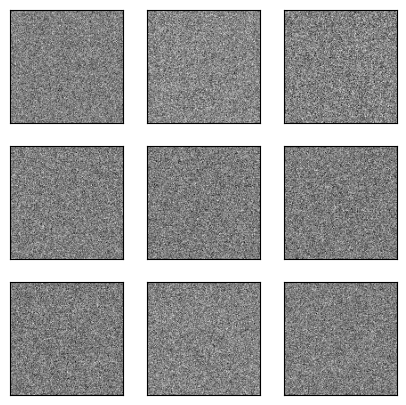

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(noised_images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)


## Checking the conformation idx of each individual image
This is a quick check that the sampled conformations actually match the distribution we specified, and a simple use of the per-image conformation info we are tracking

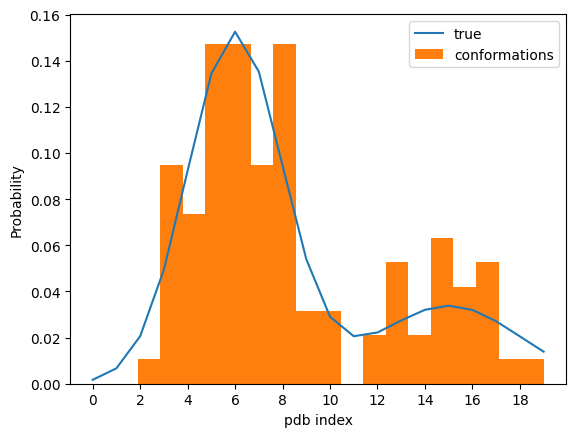

In [ ]:
# this is reading out the true conformation index of each image
conformations = extra_info["conformation"]

# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
weights = jnp.exp(mixture.log_prob(x))
weights /= weights.sum()
plt.plot(x, weights, label='true', color="C0")
plt.hist(conformations, bins=20, range=(0, 19), density=True, label='conformations', color="C1")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()


# Trying to compute likelihoods


In [ ]:
@eqx.filter_jit
def compute_log_likelihood_single_conformation(
    potential, observed_imaging_stack_vmap, observed_imaging_stack_novmap):

    observed_imaging_stack = eqx.combine(observed_imaging_stack_vmap, observed_imaging_stack_novmap)
    parameters = observed_imaging_stack.parameters

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble=structural_ensemble,
        potential_integrator=cxs.FourierSliceExtraction(interpolation_order=1),
        #potential_integrator = cxs.GaussianMixtureProjection(),
        transfer_theory=parameters.transfer_theory,
    )

    instrument_config = parameters.instrument_config

    simulated_imaging_pipeline = cxs.ContrastImagingPipeline(
        instrument_config, scattering_theory
    )

    simulated_distribution = WhiteGaussianNoise(simulated_imaging_pipeline, noise_variance=jnp.mean(noise_power_sq))
    return simulated_distribution.log_likelihood(observed_imaging_stack.image_stack) 

@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(0, None, None), out_axes=0)
def compute_log_likelihood_all_images_single_conformation(atom_positions,imaging_stack_vmap, args):

    atom_identities, b_factors, parameter_table, imaging_stack_novmap = (
        args
    )

    parameters = imaging_stack_novmap.parameters
    instrument_config = parameters.instrument_config

    atom_potential = cxs.PengAtomicPotential(
        atom_positions,
        atom_identities,
        b_factors,
        scattering_factor_parameter_table=parameter_table,
    )

    real_voxel_grid = atom_potential.as_real_voxel_grid(
        (instrument_config.shape[0],) * 3,
        instrument_config.pixel_size,
        batch_size_for_z_planes=10,
    )

    voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
        real_voxel_grid,
        instrument_config.pixel_size
    )

    likelihoods = jax.lax.map(
        lambda x: compute_log_likelihood_single_conformation(
            potential=voxel_potential, observed_imaging_stack_vmap=x, observed_imaging_stack_novmap=imaging_stack_novmap
        ),
        xs=imaging_stack_vmap,
        batch_size=10,
    )

    return likelihoods


In [ ]:
pdb_fnames = config["models_fnames"]
path_to_models = config["path_to_models"]
filename = path_to_models + "/" + pdb_fnames[0]
_, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True)
parameter_table = get_tabulated_scattering_factor_parameters(atom_identities)

args = (atom_identities, b_factors, parameter_table, imaging_stack_novmap)

atom_positions_all = []
for i in range(len(pdb_fnames)):
    filename = path_to_models + "/" + pdb_fnames[i]
    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, get_b_factors=True
    )
    atom_positions_all.append(atom_positions)
atom_positions_all = jnp.stack(atom_positions_all)
print(atom_positions_all.shape)

(20, 9758, 3)


In [ ]:
likelihood = compute_log_likelihood_all_images_single_conformation(atom_positions_all, imaging_stack_vmap, args)



[14  7  4  6  8  0  5  5  7  8  6  3  1 12  0  5  4  2 14  8 13  4  4  7
 15  1  6  3 12 13  7 14  6  3  9 17  8  8  6 11  7 14  7  6  0 14  5 14
 19  3 16  7  7  6  0  9 18 15  3  4 14  8  7  6 14  0  5  4 19 18  9  7
  6 10 17  5 19  5  7 17  9  4  8  7 15  4  7  6  6  5 15  8  7 19 15  5
  0  3  6  5]
(20, 100)
[ -6847.08774608 -11252.04033549  -6524.24541262  -7471.06433811
  -8847.07437315  -9330.71663391  -8716.28487835  -9878.10570591
  -9547.70041603 -11592.46029435]
[ -6842.60297023 -11251.94964263  -6525.84023555  -7472.43517282
  -8843.98727072  -9333.28127706  -8716.66398599  -9873.44663497
  -9548.22469286 -11586.6865284 ]


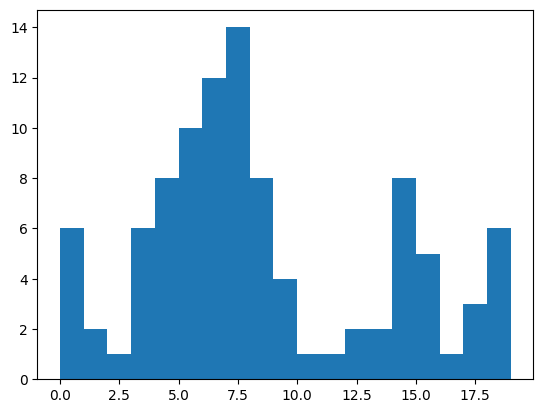

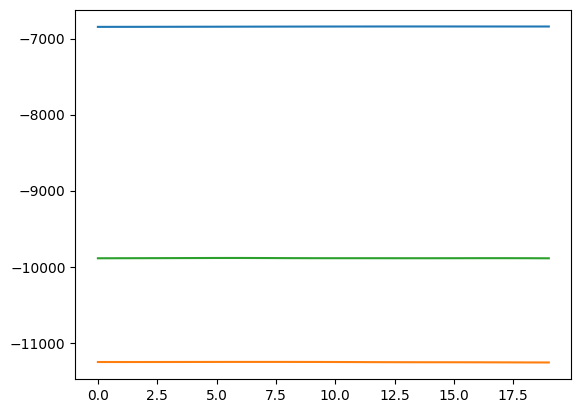

In [ ]:
x = jnp.argmax(likelihood, axis = 0)
print(x)
print(likelihood.shape)
print(likelihood[0, 0:10])
print(likelihood[10, 0:10])

plt.hist(x, bins=jnp.arange(0, 20, 1))

plt.figure()
plt.plot(likelihood[:, 0])
plt.plot(likelihood[:, 1])
plt.plot(likelihood[:, 10])


